# Simulation experiments

In [4]:
from scm import StructuralCausalModel
from recourse_model import Recourse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

pd.set_option('mode.chained_assignment', None)

## Simulating data from a Structural Causal Model

In [5]:
def simulate_data(N):

    # Define the SCM
    scm = StructuralCausalModel(N=50)

    # Fist variable is a normal distribution
    scm.add_variable(name='X1', distribution=norm, loc=0, scale=2)

    # X1 causes X2
    scm.add_relationship(causes = {'X1':3}, effect='X2', noise_dist=norm, loc=1, scale=0.5)

    # There exists an unobserved variable U
    scm.add_variable(name='U', distribution=norm, loc=0, scale=1)

    # Y is caused by X2 and U
    scm.add_binary_outcome(name='Y', weights={'X2': 0.5, 'U': -0.5}, noise_dist=norm, loc=0, scale=0)

    # X3 is caused by X1
    scm.add_relationship(causes = {'X1':-2}, effect='X3', noise_dist=norm, loc=0, scale=0.25)

    # X4 is caused by Y
    scm.add_relationship(causes ={'Y': 0.75}, effect='X4', noise_dist=norm, loc=0, scale=0.5)

    # Return object
    return scm

## Responses over time

In [13]:
def simulate_recourse(C, N, iterations=5, partial_recourse = True, re_tries=2, verbose = False):

    scm = simulate_data(N)
    data = scm.generate_data()
    X = data[['X1', 'X2', 'X3', 'X4']]
    y = data['Y']
    accuracy = []
    cost_negative = []

    for i in range(1, iterations+1):
        print(f"Iteration {i} started")

        # Fit the classifier
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        clf = LogisticRegression(penalty='l2', C=2).fit(X_train.values, y_train.values) # using Logistic regression, but any SciKitLearn classifier should work here.
        y_pred = clf.predict(X_test.values)
        y_true = scm.data[scm.data['ID'].isin(y_test.index)].Y
        accuracy.append(np.sum(y_pred == y_true) / len(y_true))
        y_pred = clf.predict(X.values)

        if np.min(y_pred)==1:
            print("All predicted 1")
            change_cost = (cost_negative[-1]/cost_negative[0])-1
            return accuracy, cost_negative, change_cost

        # Compute recourse
        recourse_model = Recourse(X, y_pred, clf)
        recourse_model.compute_recourse(C, partial_recourse=partial_recourse, verbose=verbose, re_tries=re_tries)

        if (recourse_model.recourse.Y == 1).all():
            print("finished")
            change_cost = (cost_negative[-1]/cost_negative[0])-1
            return accuracy, cost_negative, change_cost

        # Calculate average cost of recourse for negatively classified points
        cost_negative.append(np.mean(recourse_model.recourse['cost']))

        # Update the SCM with the new data
        scm.append_data(recourse_model.recourse[['X1', 'X2', 'X3', 'X4']], ids = recourse_model.recourse.index.to_series())
        scm.data.drop_duplicates(subset ="ID", keep = 'last', inplace = True)

        # Update X and y
        X.update(recourse_model.recourse[['X1', 'X2', 'X3', 'X4']])
        y.update(recourse_model.recourse['Y'])

    change_cost = (cost_negative[-1]/cost_negative[0])-1
    return accuracy, cost_negative, change_cost

In [14]:
def plot(accuracy, cost_negative, C):
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Accuracy')
    ax1.plot(accuracy, color='tab:blue')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Average cost of negatively classified')  # we already handled the x-label with ax1
    ax2.plot(cost_negative, color='tab:red')
    ax2.tick_params(axis='y')

    # add legend
    fig.legend(labels=['Accuracy', 'Cost'])
    fig.suptitle(f"C = {C}")
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

Iteration 1 started
Iteration 2 started
Iteration 3 started
Iteration 4 started
Iteration 5 started
Iteration 6 started
Iteration 7 started
Iteration 8 started
Iteration 9 started
Iteration 10 started


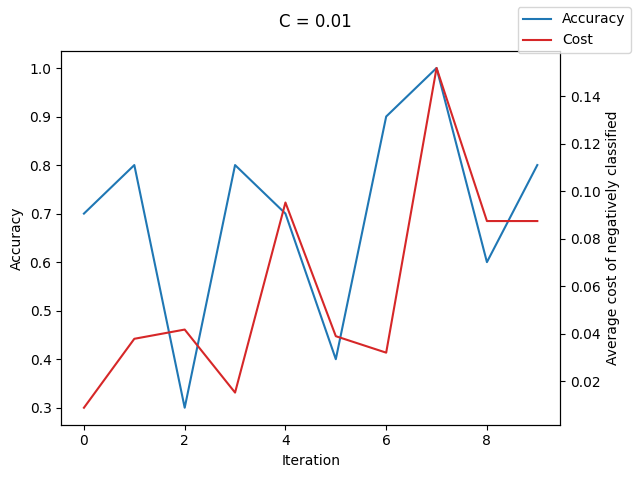

In [18]:
accuracy, cost_negative, change_cost = simulate_recourse(C=0.01, N=300, iterations=10, partial_recourse = True, verbose=False)
plot(accuracy, cost_negative, 0.01)

Iteration 1 started
Iteration 2 started
Iteration 3 started
Iteration 4 started
Iteration 5 started
Iteration 6 started
Iteration 7 started
Iteration 8 started
Iteration 9 started
Iteration 10 started


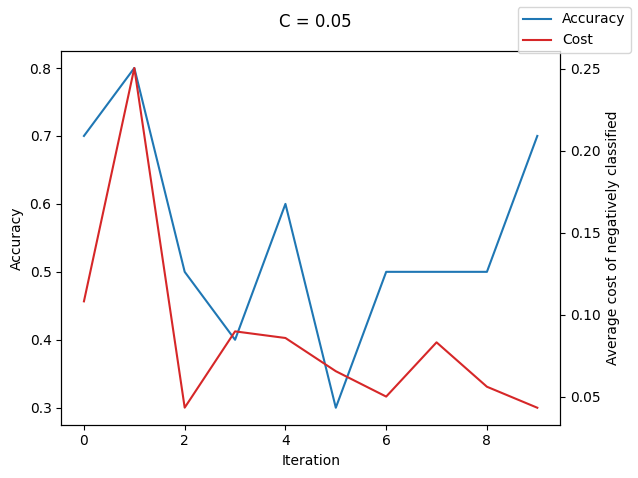

In [15]:
accuracy, cost_negative, change_cost = simulate_recourse(C=0.05, N=300, iterations=10, partial_recourse = True, verbose=False)
plot(accuracy, cost_negative, 0.05)

Iteration 1 started
Iteration 2 started
Iteration 3 started
Iteration 4 started
Iteration 5 started
Iteration 6 started
Iteration 7 started
finished


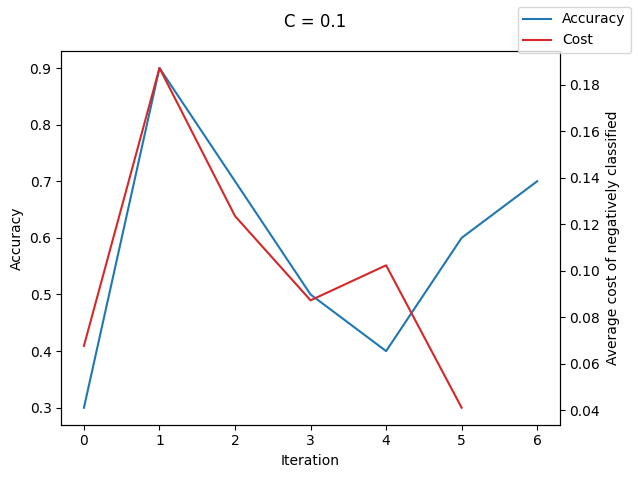

In [16]:
accuracy, cost_negative, change_cost = simulate_recourse(C=0.05, N=300, iterations=10, partial_recourse = True, verbose=False)
plot(accuracy, cost_negative, 0.1)

Iteration 1 started
Iteration 2 started
Iteration 3 started
Iteration 4 started
Iteration 5 started
Iteration 6 started
Iteration 7 started
Iteration 8 started
finished


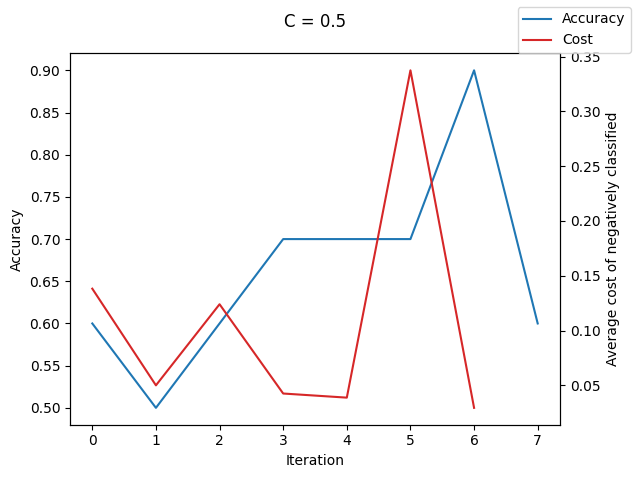

In [17]:
accuracy, cost_negative, change_cost = simulate_recourse(C=0.05, N=300, iterations=10, partial_recourse = True, verbose=False)
plot(accuracy, cost_negative, 0.5)